# TP1 - Grupo 4 - Pasajeros

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
import scipy.stats
import pylab
import statsmodels.tsa.stattools as tsa
import pmdarima as pm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

##########################################################################################
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime
from statsmodels.tsa.arima_model import ARMA
from pmdarima.arima import ADFTest
##########################################################################################

from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20,10)})

In [2]:
## Función para dibujar juntos FAS: autocovarianzas; FAC (autocorrelacion ) y FACP (autocorrelación parcial)
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  axes[2,1].set_xlabel('Lag')

  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Serie: Pasajeros')
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')

  plot_acf(serie_nr, lags=nrol, ax= axes[0,1], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Serie: Pasajeros diferenciado')
  plot_pacf(serie_nr, lags=nrol, ax= axes[1,1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,1].plot(tsa.acovf(serie_nr,fft=False, nlag=nrol), color='r', label='AutoCov')

  p1.legend()
  plt.show()

# Pasajeros 

Pasajeros por línea a partir del 30 de septiembre del 2021

In [3]:
url='https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Pasajeros_TP.csv'
pasajeros_d = pd.read_csv(url)
pasajeros_d.rename({'FechaRecaudacion': 'fecha', 'Cantidad_Pasajeros': 'pas'}, axis=1, inplace=True)

In [4]:
# Para la fecha jueves 13 de octubre del 2022, se observa el valor de 1 y para corregir este dato se optó por sacar el promedio de los dos dias posteriores y el valor del día anterior.
# Además se agregan las observaciones que corresponden a los días 2022-05-17, 2022-10-12 y 2023-06-13 con el valor de 1, posteriormente se reemplaza este valor por el promedio de los dos dias posteriores y el valor del día anterior.
# Agregar fechas faltantes
nuevas_observaciones = pd.DataFrame([{'fecha': '2022-05-17', 'pas': 1},
                                     {'fecha': '2022-10-12', 'pas': 1},
                                     {'fecha': '2023-06-13', 'pas': 1},
                                     {'fecha': '2023-06-22', 'pas': 1}])
pasajeros_d = pd.concat([pasajeros_d, nuevas_observaciones], ignore_index=True)

In [5]:
# Ordenar el DataFrame por la columna de fechas
pasajeros_d = pasajeros_d.sort_values(by='fecha', ascending=True)

# Resetear el índice
pasajeros_d = pasajeros_d.reset_index(drop=True)

# Convertir la columna 'Fecha' a tipo datetime
pasajeros_d['fecha'] = pd.to_datetime(pasajeros_d['fecha'], dayfirst=True)

In [6]:
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_17 = round(average_value_17, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_17

In [7]:
# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_12 = round(average_value_12, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_12

In [8]:
# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_13 = round(average_value_13, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_13

In [9]:
# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_6 = round(average_value_6, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_6

In [10]:
# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_22 = round(average_value_22, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_22

In [11]:
# Formato diario
pasajeros_d.set_index('fecha', inplace=True)

pasajeros_d.head()

,pas
fecha,
2021-09-30,153297
2021-10-01,163933
2021-10-02,71862
2021-10-03,41802
2021-10-04,159940


In [12]:
pasajeros_d = pasajeros_d.asfreq('d')
pasajeros_d

,pas
fecha,
2021-09-30,153297
2021-10-01,163933
2021-10-02,71862
2021-10-03,41802
2021-10-04,159940
...,...
2023-10-26,299281
2023-10-27,285229
2023-10-28,148798


In [13]:
pasajeros_d = pasajeros_d['pas']
pasajeros_d.describe()

count       761.000000
mean     175922.908016
std       82446.842200
min        5582.000000
25%      106221.000000
50%      178296.000000
75%      249682.000000
max      319953.000000
Name: pas, dtype: float64

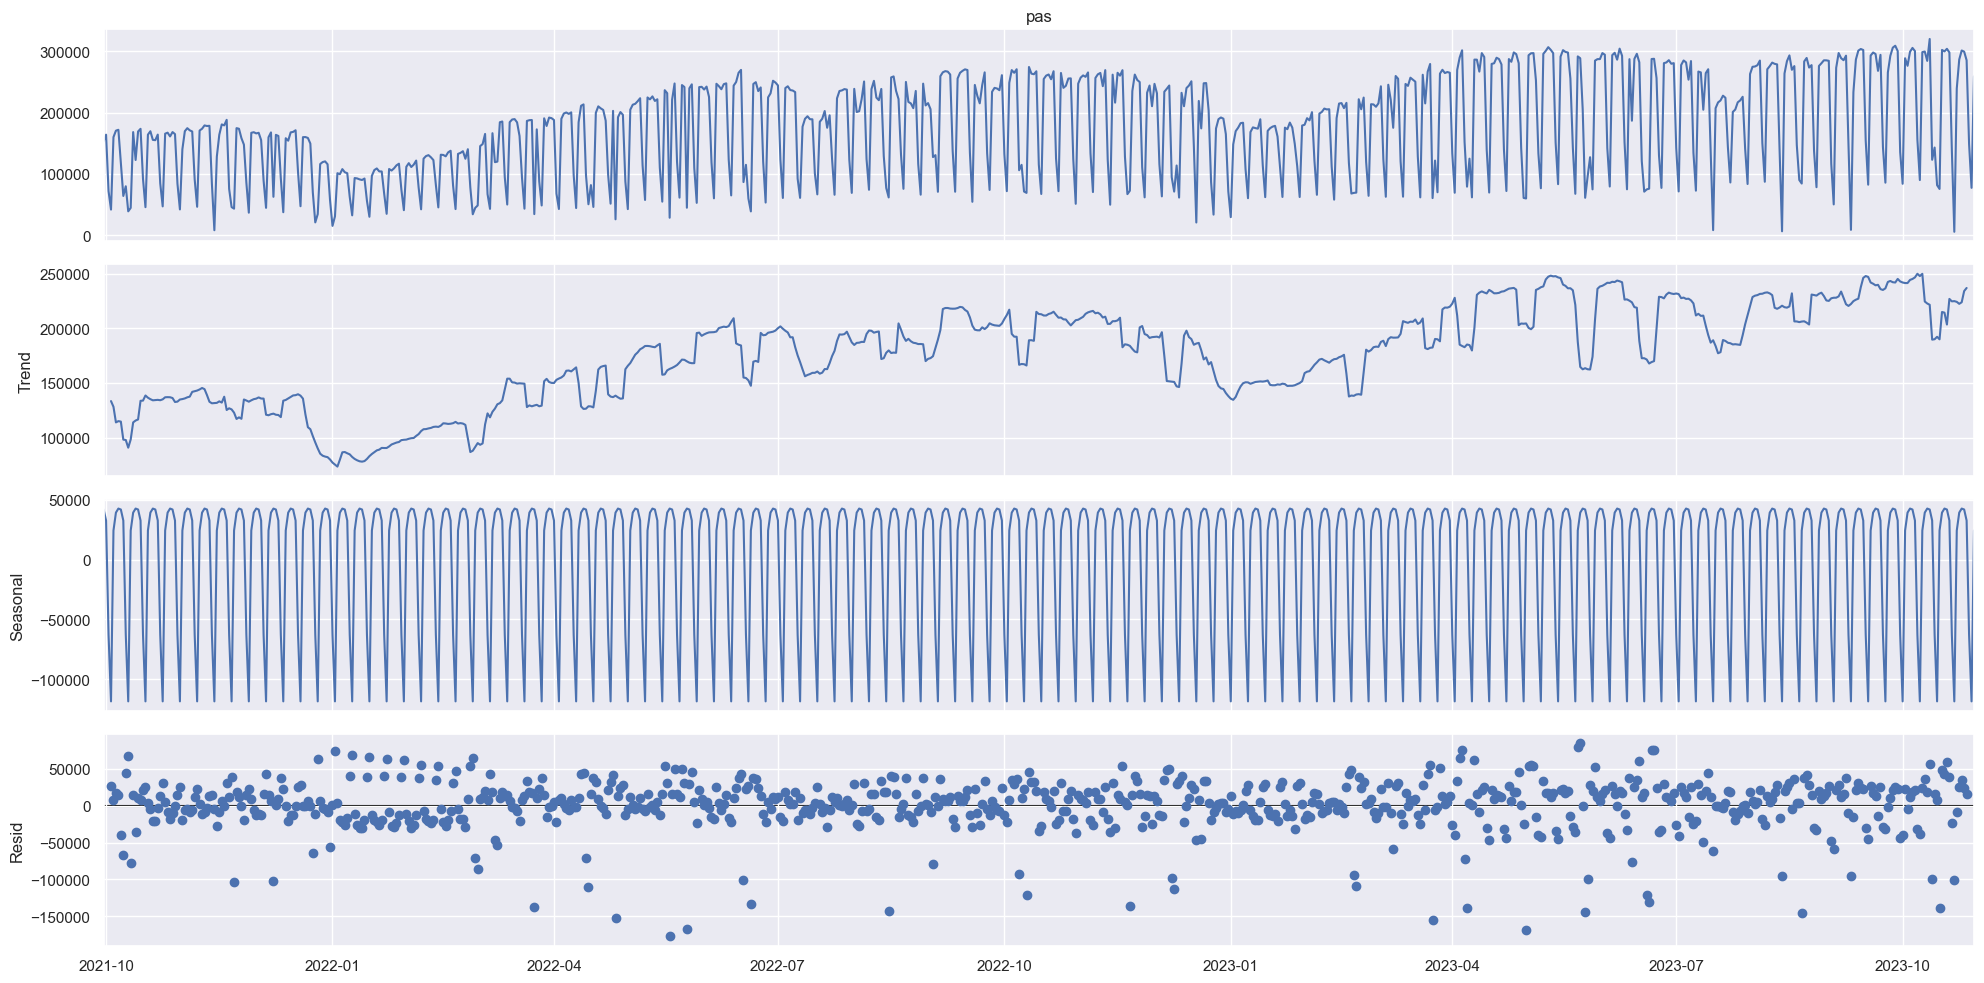

In [14]:
#Descomposición aditiva de la serie diferenciada
from statsmodels.tsa.seasonal import seasonal_decompose

s_dec_additive = seasonal_decompose(pasajeros_d, model = "adittive")
s_dec_additive.plot()
plt.show()

# Pregunta 2

Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. Exponer los conceptos relacionados con la estacionariedad de la serie.

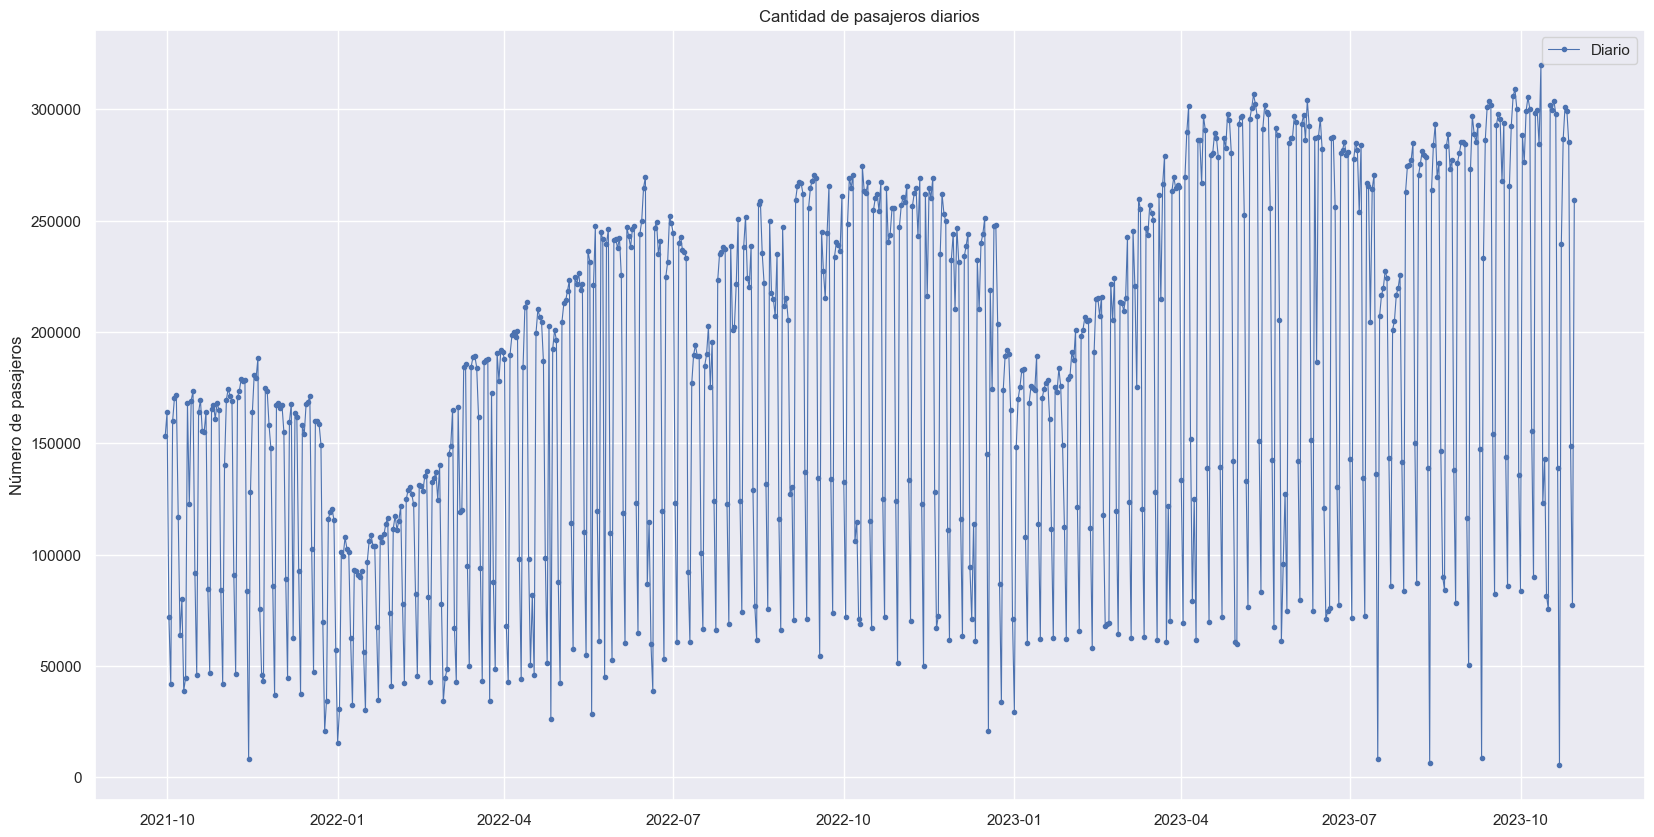

In [15]:
#Visualización serie original

plt.plot(pasajeros_d.loc['2021-09':,], marker='.', linestyle='-', linewidth=0.8, label='Diario')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.title('Cantidad de pasajeros diarios')
plt.show()

In [34]:
# Pasajeros
#pasajeros_d.pas.plot(figsize=(35,8), title = 'Serie original');

La serie diaria de pasajeros muestra una baja en los meses de verano y un incremento luego del inicio de clases. Además se puede ver que del 2022 al 2023 hubo una mayor cantidad de pasajeros si se trata de comparar con el día del año anterior.

Por lo tanto se opta por diferenciar esta serie para que sea estacionaria, ya que de forma visual hay una clara tendencia creciente y una estacionalidad marcada.

Para determinar el número de diferenciaciones necesarias para que una serie temporal sea estacionaria utilizamos pm.arima.ndiffs:

In [16]:
print(pm.arima.ndiffs(pasajeros_d))

1


In [19]:
# Diferenciar la serie
pas_diff=pasajeros_d.copy()
pas_diff=pas_diff.diff(periods = 1)
pas_diff = pas_diff.dropna()

In [20]:
# Funcion para graficar

def graficar(serie, titulo="", xlabel="Mes", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])
    serie.plot()
    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

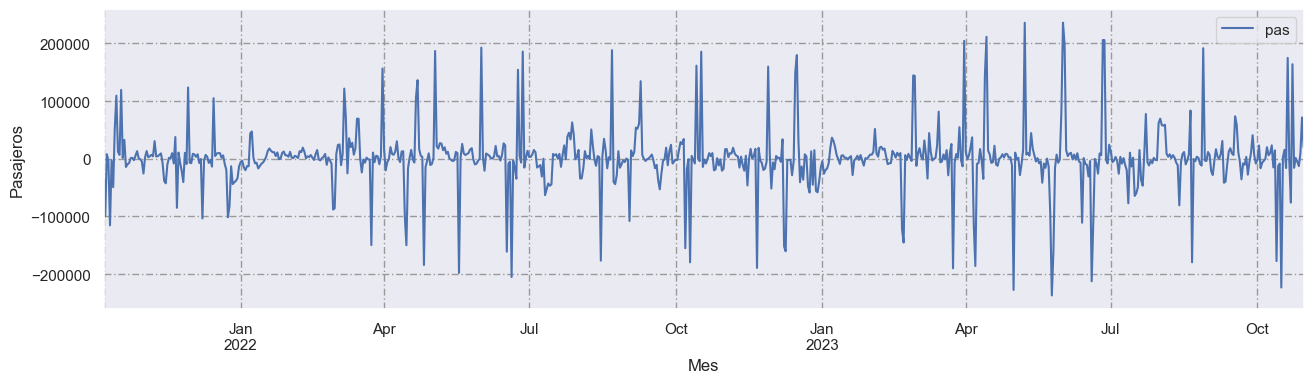

In [21]:
# Para remover la estacionalidad semanal,
# Hacemos una diferencia semanal y en el grafico ya no observamos un patron repetitivo

# Diferenciar la serie
pas_diff_7=pasajeros_d.copy()
pas_diff_7=pas_diff_7.diff(periods = 7)
pas_diff_7 = pas_diff_7.dropna()
graficar(pas_diff_7)


# Pregunta 3

Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría

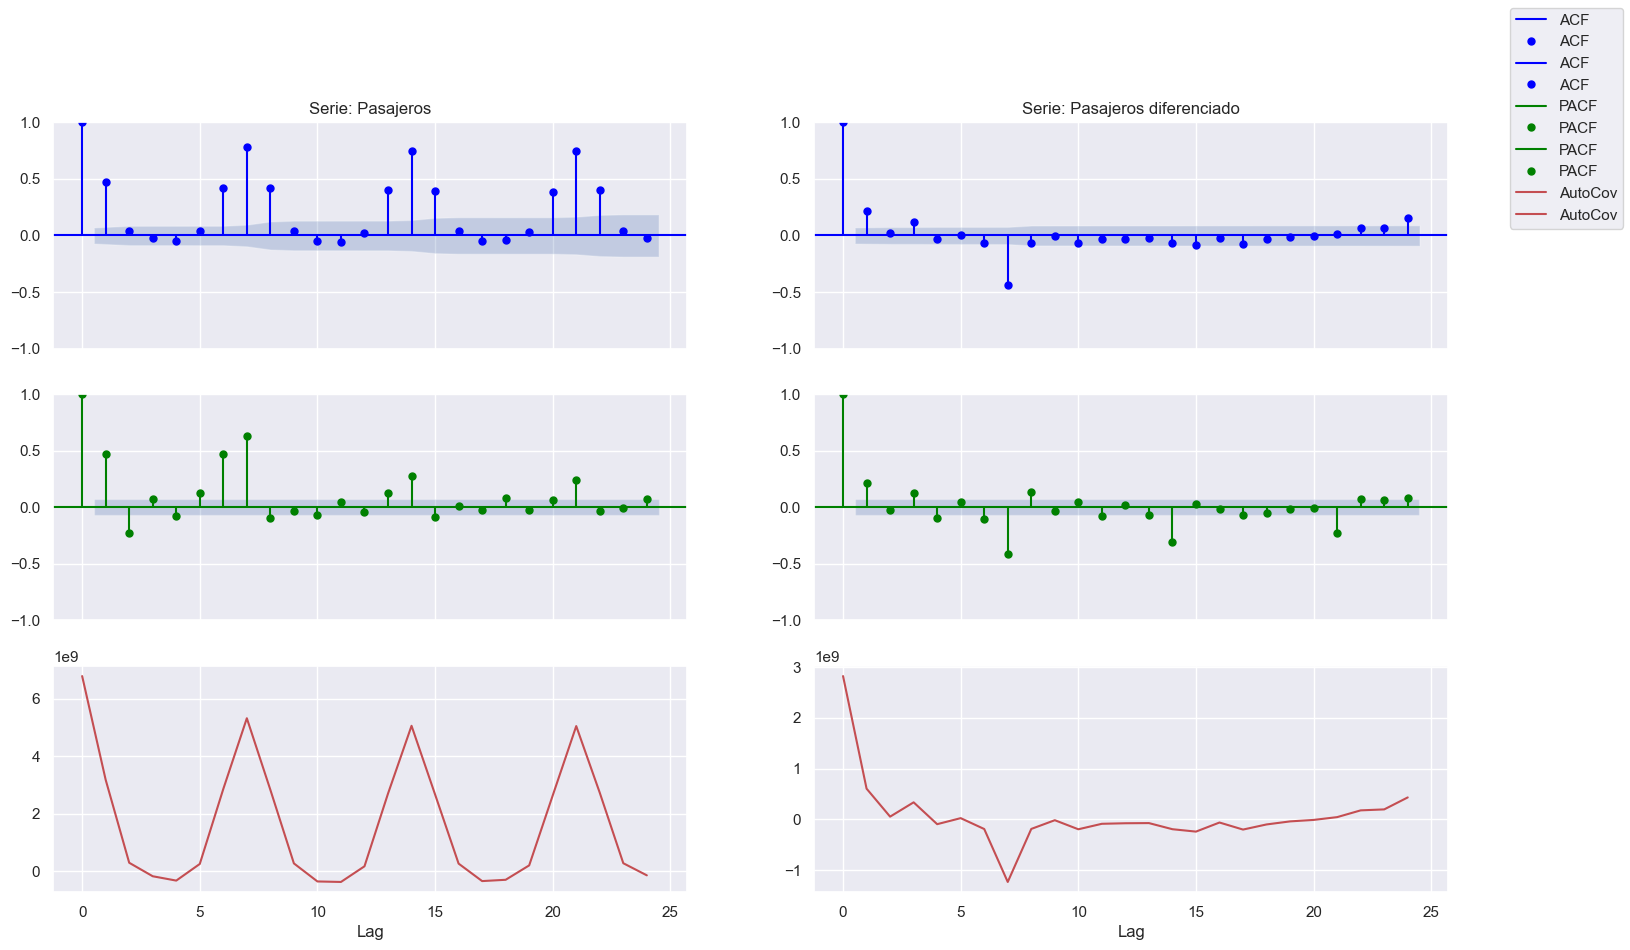

In [22]:
# Grafica diferentes funciones de la serie Pasajeros
autocov_autocorr(pasajeros_d, pas_diff_7, 24)

# Pregunta 4

Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.

In [23]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Results of Dickey-Fuller Test for column: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Reject the null hypothesis")
    print("Data is stationary")
  else:
    print("Conclusion:====>")
    print("Fail to reject the null hypothesis")
    print("Data is non-stationary")

In [24]:
# Dicky Fuller Serie original
Augmented_Dickey_Fuller_Test_func(pasajeros_d,'pas')

Results of Dickey-Fuller Test for column: pas
Test Statistic                  -1.459919
p-value                          0.553238
No Lags Used                    20.000000
Number of Observations Used    740.000000
Critical Value (1%)             -3.439218
Critical Value (5%)             -2.865454
Critical Value (10%)            -2.568854
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [25]:
# Dicky Fuller Serie pas_diff
Augmented_Dickey_Fuller_Test_func(pas_diff,'pas')

Results of Dickey-Fuller Test for column: pas
Test Statistic                -1.183676e+01
p-value                        7.757945e-22
No Lags Used                   1.900000e+01
Number of Observations Used    7.400000e+02
Critical Value (1%)           -3.439218e+00
Critical Value (5%)           -2.865454e+00
Critical Value (10%)          -2.568854e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [26]:
# Dicky Fuller Serie pas_diff_7
Augmented_Dickey_Fuller_Test_func(pas_diff_7,'pas')

Results of Dickey-Fuller Test for column: pas
Test Statistic                -1.074252e+01
p-value                        2.794540e-19
No Lags Used                   2.000000e+01
Number of Observations Used    7.330000e+02
Critical Value (1%)           -3.439303e+00
Critical Value (5%)           -2.865491e+00
Critical Value (10%)          -2.568874e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


# Pregunta 5

Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual global de los parámetros del modelo).

In [27]:
# Separacion Train/Test
# Seleccionamos el primer 90% para train
train = pasajeros_d.iloc[:round(len(pasajeros_d)*.90)]

# Seleccionamos el 10% restante para test
test = pasajeros_d.iloc[round(len(pasajeros_d)*.90):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train, test)

fecha
2021-09-30    153297
2021-10-01    163933
2021-10-02     71862
2021-10-03     41802
2021-10-04    159940
               ...  
2023-08-11    278504
2023-08-12    138898
2023-08-13      6397
2023-08-14    263675
2023-08-15    283780
Freq: D, Name: pas, Length: 685, dtype: int64 fecha
2023-08-16    293162
2023-08-17    269716
2023-08-18    275728
2023-08-19    146723
2023-08-20     90065
               ...  
2023-10-26    299281
2023-10-27    285229
2023-10-28    148798
2023-10-29     77246
2023-10-30    259062
Freq: D, Name: pas, Length: 76, dtype: int64


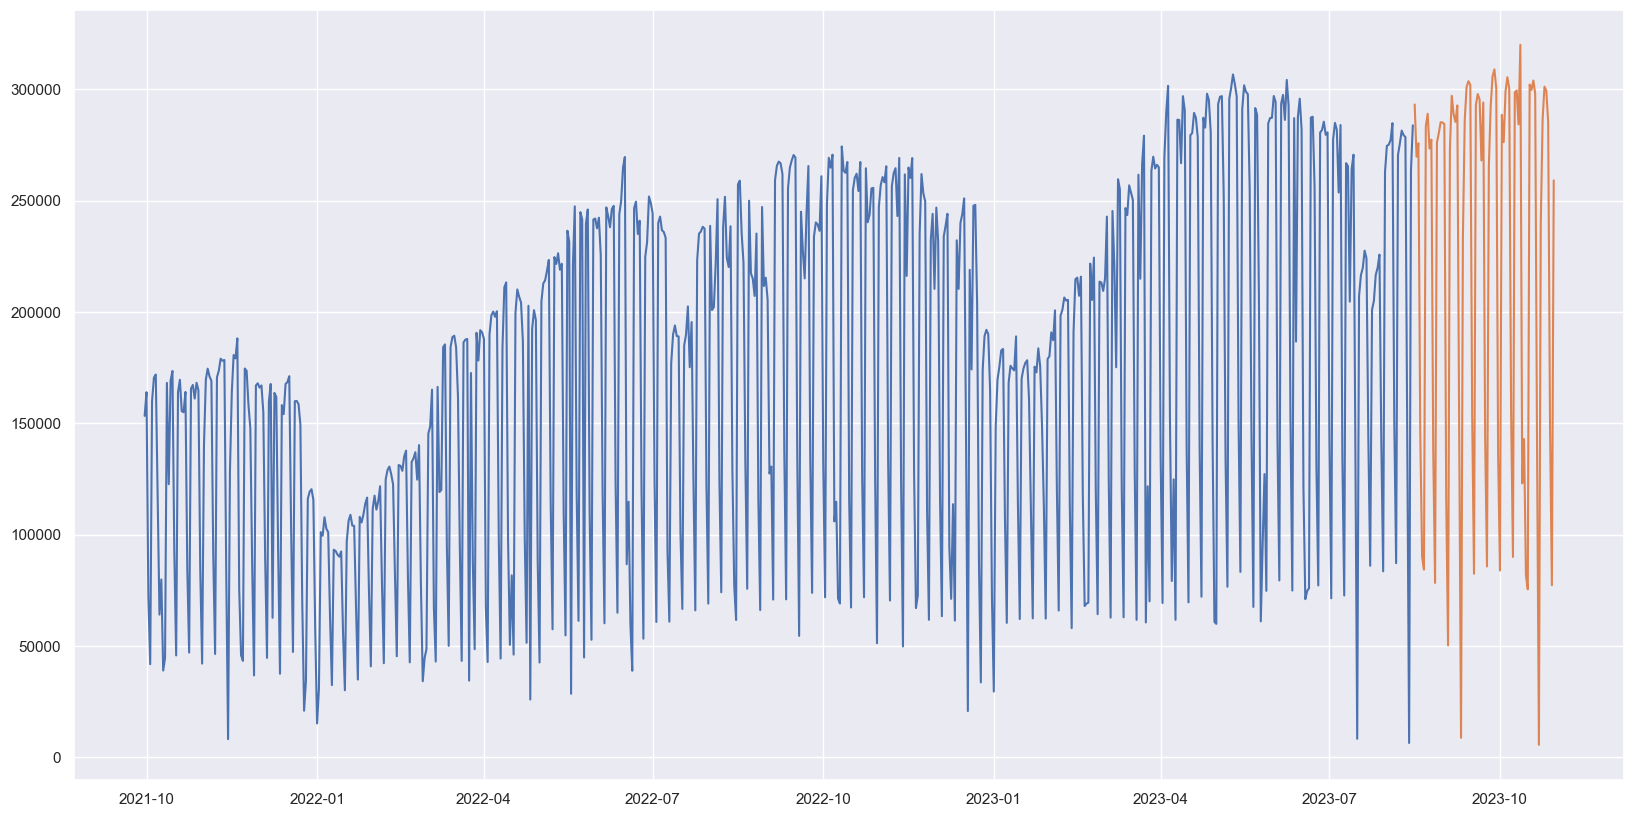

In [28]:
# Visualización Train - Test

plt.plot(train)
plt.plot(test)

In [29]:
# Usamos la funcion auto_arima del paquete pmdarima para optimizar la combinacion de hiperparametros para el modelo SARIMA

auto_arima(train, start_p=0, max_p=5, start_d=1, max_d=5, start_q=0, max_q=5,
                            start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
                            seasonal=True, m=7, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17431.743, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17076.367, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=17096.556, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17429.747, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17425.384, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=17034.159, Time=0.21 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=17020.075, Time=0.52 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=16982.913, Time=1.06 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=16980.970, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=16979.649, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=17218.548, Time=0.09 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=16980.791, Time=0.45 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=17145.084, Time=0.18 sec
 ARIMA(1,1,0)(2,0,2)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  685
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -8238.951
Date:                             Wed, 29 Nov 2023   AIC                          16495.902
Time:                                     19:39:26   BIC                          16536.654
Sample:                                 09-30-2021   HQIC                         16511.672
                                      - 08-15-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2960      0.887      0.334      0.739      -1.442       2.034
ar.L2         -0.1287      0.288     -0.447      0.655      -0.694       0.436
ar.L3          0.0640      0.104      0.617      0.537      -0.139       0.267
ar.L4         -0.0828      0.083     -0.996      0.319      -0.246       0.080
ma.L1         -0.9363      0.883     -1.060      0.289      -2.667       0.794
ma.L2          0.0114      0.827      0.014      0.989      -1.609       1.632
ar.S.L7        0.9978      0.003    342.697      0.000       0.992       1.004
ma.S.L7       -0.9284      0.027    -34.560      0.000      -0.981      -0.876
sigma2      2.238e+09   6.61e-10   3.39e+18      0.000    2.24e+09    2.24e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1511.49
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.67e+34. Standard errors may be unstable.
"""

In [30]:
modelo_sarima = SARIMAX(train, order=(4,1,2), seasonal_order=(1,0,1,7), trend='n')
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 pas   No. Observations:                  685
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -8238.951
Date:                             Wed, 29 Nov 2023   AIC                          16495.902
Time:                                     19:39:41   BIC                          16536.654
Sample:                                 09-30-2021   HQIC                         16511.672
                                      - 08-15-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2960      0.887      0.334      0.739      -1.442       2.034
ar.L2         -0.1287      

# Pregunta 6

Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

In [31]:
# Función para graficar

def graficar_pred(serie_test, serie_pred, conf_int, titulo="Valores Originales vs Predicciones", xlabel="Meses", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones")

    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos
    conf_int.iloc[:,1].plot(label="Intervalo de Confianza Superior")
    conf_int.iloc[:,0].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

In [32]:
#Función para evaluar los modelos contra el test en MSE, MAE, RMSE, MAPE
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [33]:
# Utilizando el modelo realizamos la prediccion correspondiente a los primeros 50 días del test
predicciones_sarima = modelo_sarima.get_forecast(50)

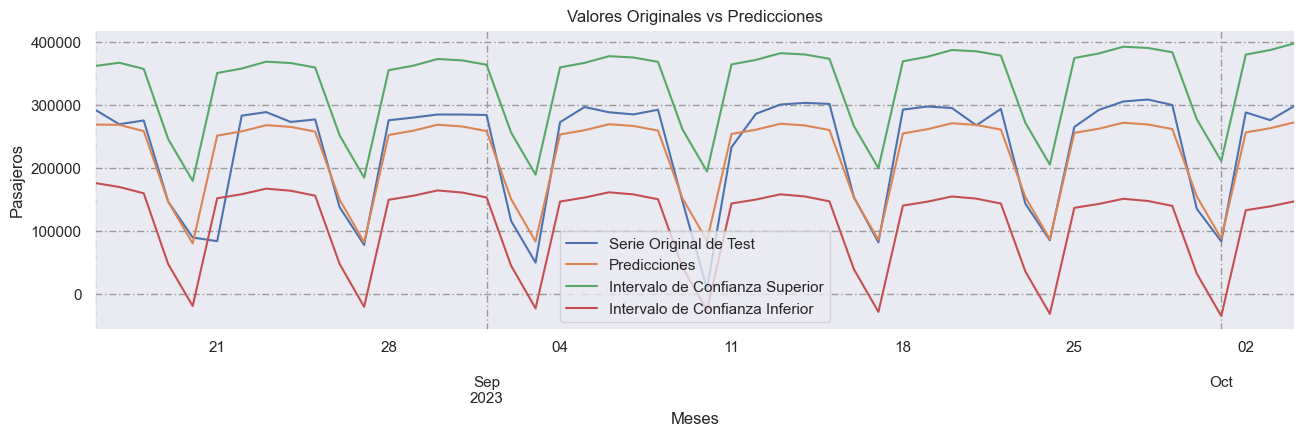

In [34]:
# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test[:50], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int())

In [35]:
#Evaluamos las métricas del modelo
evaluar_metricas(test[:50], predicciones_sarima.predicted_mean )

MSE: 1229452681.4228244
MAE: 24722.958475748263
RMSE: 35063.55203659242
MAPE: 0.3044


# Pregunta 7

Detallar una comparación con otros modelos estimados

In [36]:
# Pruebo el autoarima sin estacionalidad ( " seasonal = False ")
auto_arima(train, start_p=0, max_p=5, start_d=0, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=False, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17431.743, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17425.384, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17265.469, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17429.747, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17211.151, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17124.337, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17335.236, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17118.479, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17321.463, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=17048.177, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=17272.730, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=16896.197, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=17054.194, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=16785.182, Time=0.73 sec
 ARIMA(4,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  685
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -8383.622
Date:                Wed, 29 Nov 2023   AIC                          16783.245
Time:                        19:40:10   BIC                          16819.468
Sample:                    09-30-2021   HQIC                         16797.262
                         - 08-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2029      0.033      6.091      0.000       0.138       0.268
ar.L2         -0.7235      0.029    -24.679      0.000      -0.781      -0.666
ar.L3         -0.2554      0.036     -7.177      0.000      -0.325      -0.186
ar.L4         -0.3793      0.026    -14.652      0.000      -0.430      -0.329
ar.L5         -0.4910      0.033    -14.935      0.000      -0.555      -0.427
ma.L1         -0.9488      0.034    -28.098      0.000      -1.015      -0.883
ma.L2          0.6258      0.028     21.971      0.000       0.570       0.682
sigma2      2.238e+09   8.93e-12   2.51e+20      0.000    2.24e+09    2.24e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):               144.01
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+36. Standard errors may be unstable.
"""

In [37]:
modelo_arima = sm.tsa.arima.ARIMA(train, order=(5,1,2), seasonal_order=(0, 0, 0, 0))
modelo_arima = modelo_arima.fit()

modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    pas   No. Observations:                  685
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -8383.622
Date:                Wed, 29 Nov 2023   AIC                          16783.245
Time:                        19:40:21   BIC                          16819.468
Sample:                    09-30-2021   HQIC                         16797.262
                         - 08-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2029      0.033      6.091      0.000       0.138       0.268
ar.L2         -0.7235      0.029    -24.679      0.000      -0.781      -0.666
ar.L3         -0.2554      0.036     -7.177      0.000      -0.325      -0.186
ar.L4         -0.3793      0.026    -14.652      0.000      -0.430      -0.329
ar.L5         -0.4910      0.033    -14.935      0.000      -0.555      -0.427
ma.L1         -0.9488      0.034    -28.098      0.000      -1.015      -0.883
ma.L2          0.6258      0.028     21.971      0.000       0.570       0.682
sigma2      2.238e+09   8.93e-12   2.51e+20      0.000    2.24e+09    2.24e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):               144.01
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+36. Standard errors may be unstable.
"""

In [38]:
predicciones_arima = modelo_arima.get_forecast(len(test))

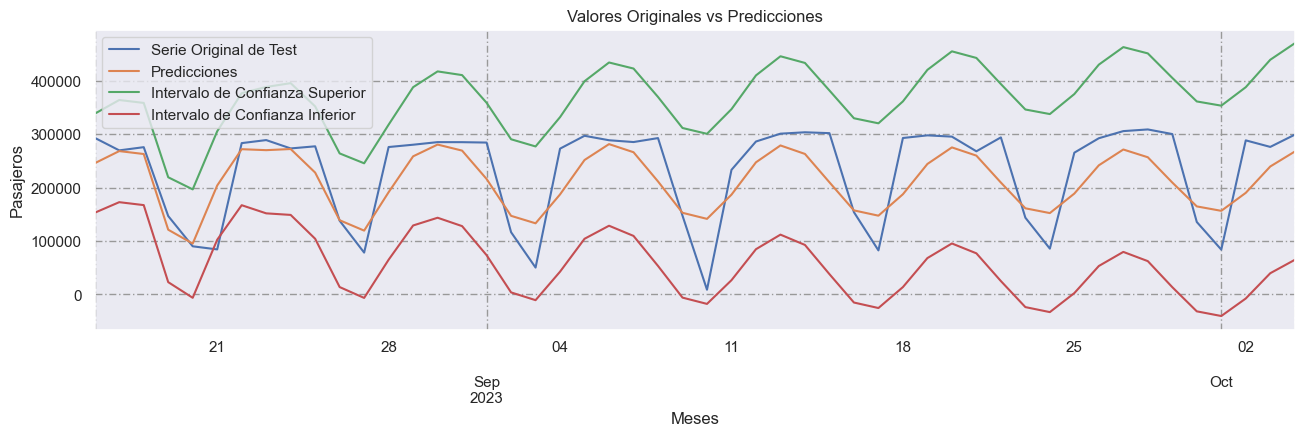

In [39]:
predicciones_arima = modelo_arima.get_forecast(50)

graficar_pred(test[:50], predicciones_arima.predicted_mean, predicciones_arima.conf_int())

In [40]:
evaluar_metricas(test[:50], predicciones_arima.predicted_mean)

MSE: 3200370064.3838673
MAE: 45144.52757194116
RMSE: 56571.81333830362
MAPE: 0.5506


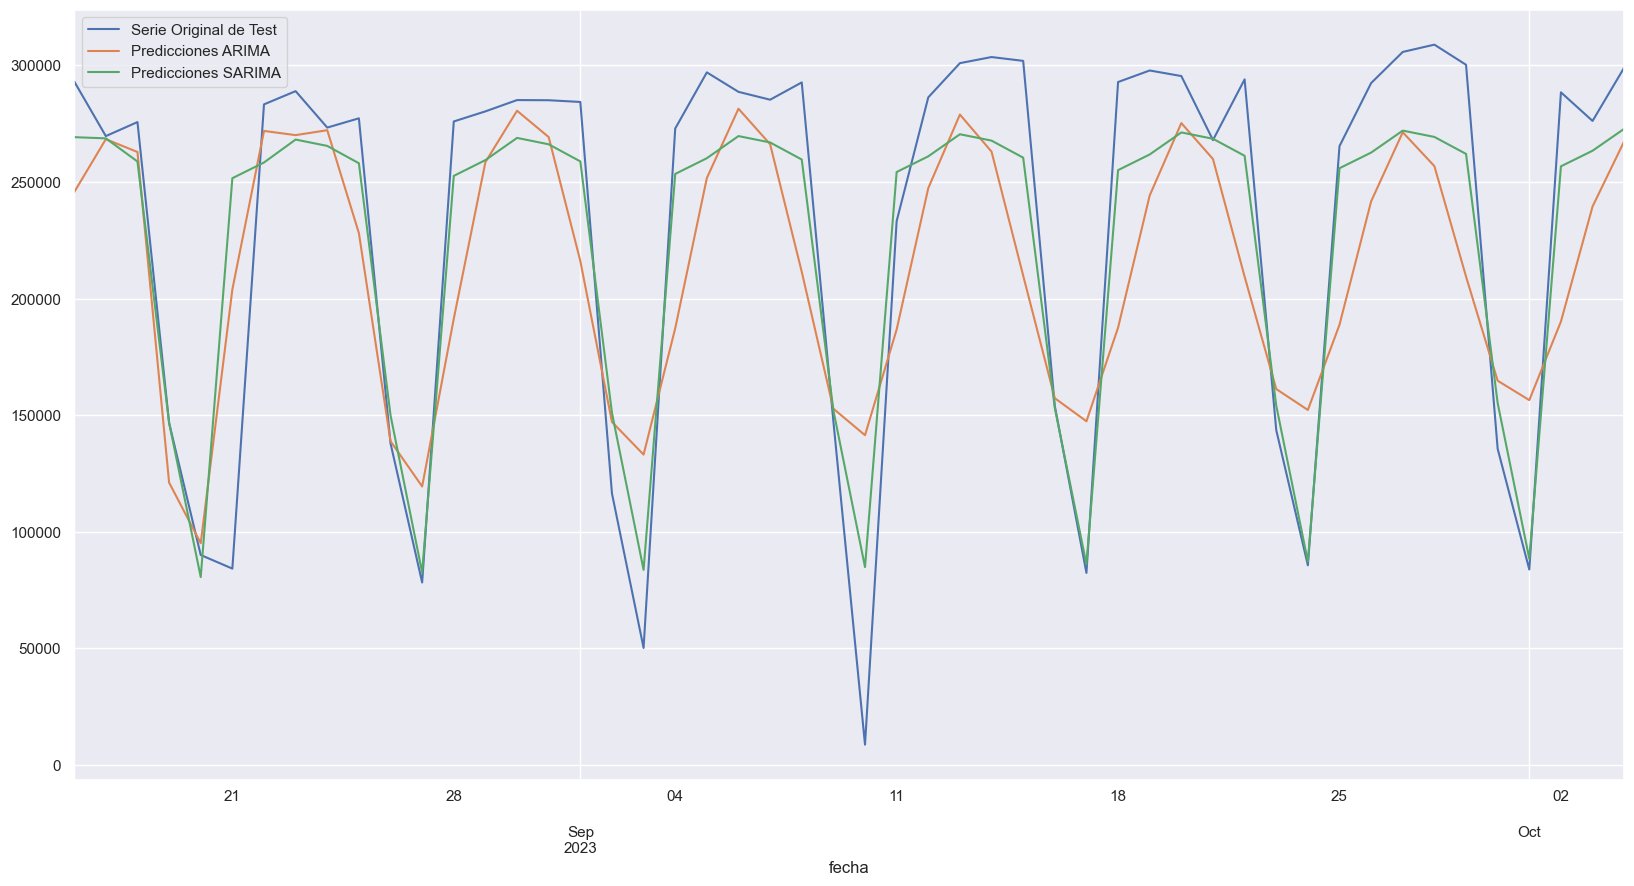

In [41]:
test[:50].plot(label="Serie Original de Test")
predicciones_arima.predicted_mean.plot(label="Predicciones ARIMA")
predicciones_sarima.predicted_mean.plot(label="Predicciones SARIMA")
plt.legend()

In [42]:
datos = {'Modelos': ['SARIMA','ARIMA'],
         'AIC': [modelo_sarima.aic, modelo_arima.aic],
         'BIC': [modelo_sarima.bic, modelo_arima.bic],
         'MAE': [modelo_sarima.mae, modelo_arima.mae],
         'MSE': [modelo_sarima.mse, modelo_arima.mse]}


modelos_residuos = pd.DataFrame(datos)
modelos_residuos

,Modelos,AIC,BIC,MAE,MSE
0,SARIMA,16495.902137,16536.653758,27713.094603,1.640858e+09
1,ARIMA,16783.244625,16819.468288,36515.322657,2.600259e+09


fecha
2021-10-07    -36482.0
2021-10-08    -99892.0
2021-10-09      7968.0
2021-10-10     -2873.0
2021-10-11   -115388.0
                ...   
2023-08-12    -11232.0
2023-08-13    -80756.0
2023-08-14     -6885.0
2023-08-15      8160.0
2023-08-16     11736.0
Freq: D, Name: pas, Length: 679, dtype: float64 fecha
2023-08-17     -9687.0
2023-08-18     -2776.0
2023-08-19      7825.0
2023-08-20     83668.0
2023-08-21   -179438.0
                ...   
2023-10-26     -4638.0
2023-10-27    -12722.0
2023-10-28     10067.0
2023-10-29     71664.0
2023-10-30     19742.0
Freq: D, Name: pas, Length: 75, dtype: float64


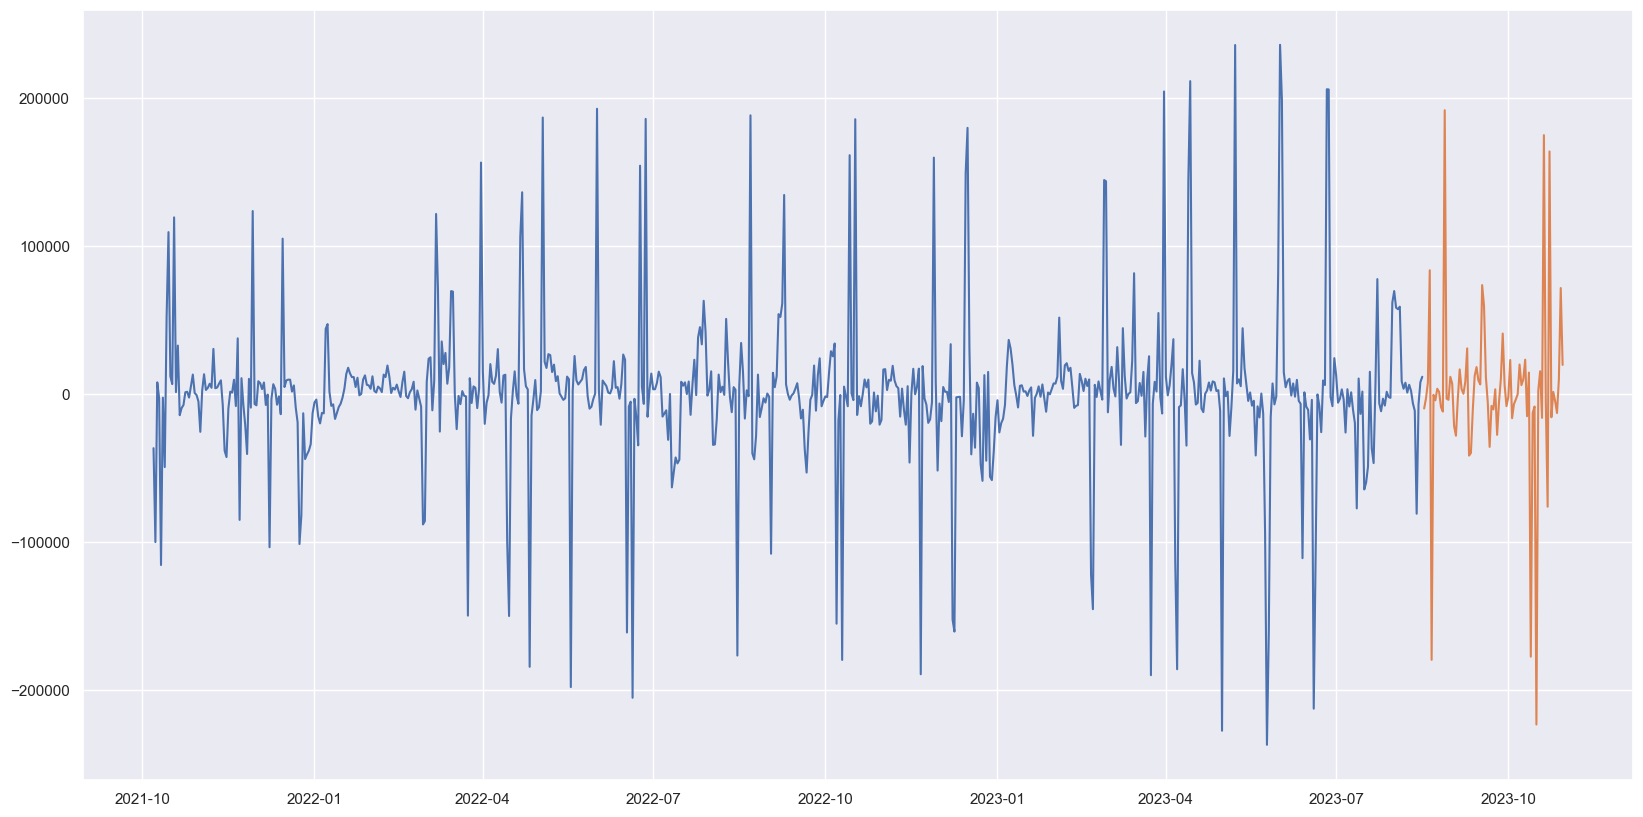

In [43]:
# Separacion Train/Test la serie diferenciada sin estacionalidad
# Seleccionamos el primer 80% para train
train_diff_7 = pas_diff_7.iloc[:round(len(pas_diff_7)*.90)]

# Seleccionamos el 20% restante para test
test_diff_7 = pas_diff_7.iloc[round(len(pas_diff_7)*.90):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train_diff_7, test_diff_7)

# Visualización Train - Test

plt.plot(train_diff_7)
plt.plot(test_diff_7)

In [44]:
# Pruebo el autoarima sin estacionalidad ( " seasonal = False ")
auto_arima(train_diff_7, start_p=0, max_p=5, start_d=0, max_d=5, start_q=0, max_q=5,
           start_P=0, max_P=5, start_D=0, max_D=5, start_Q=0, max_Q=5,
           seasonal=False, trace=True, stepwise=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16691.365, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16647.305, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16643.637, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16644.278, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16644.978, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16645.817, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16645.508, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.276 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  679
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -8319.819
Date:                Wed, 29 Nov 2023   AIC                          16643.637
Time:                        19:41:07   BIC                          16652.679
Sample:                    10-07-2021   HQIC                         16647.137
                         - 08-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2851      0.028     10.311      0.000       0.231       0.339
sigma2      2.578e+09   3.23e-12   7.98e+20      0.000    2.58e+09    2.58e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1309.10
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [45]:
modelo_arima = sm.tsa.arima.ARIMA(train_diff_7, order=(0,0,1), seasonal_order=(0, 0, 0, 0), trend='n')
modelo_arima = modelo_arima.fit()

modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    pas   No. Observations:                  679
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -8319.819
Date:                Wed, 29 Nov 2023   AIC                          16643.637
Time:                        19:41:19   BIC                          16652.679
Sample:                    10-07-2021   HQIC                         16647.137
                         - 08-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2851      0.028     10.311      0.000       0.231       0.339
sigma2      2.578e+09   3.23e-12   7.98e+20      0.000    2.58e+09    2.58e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1309.10
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [46]:
predicciones_arima = modelo_arima.get_forecast(len(test_diff_7))

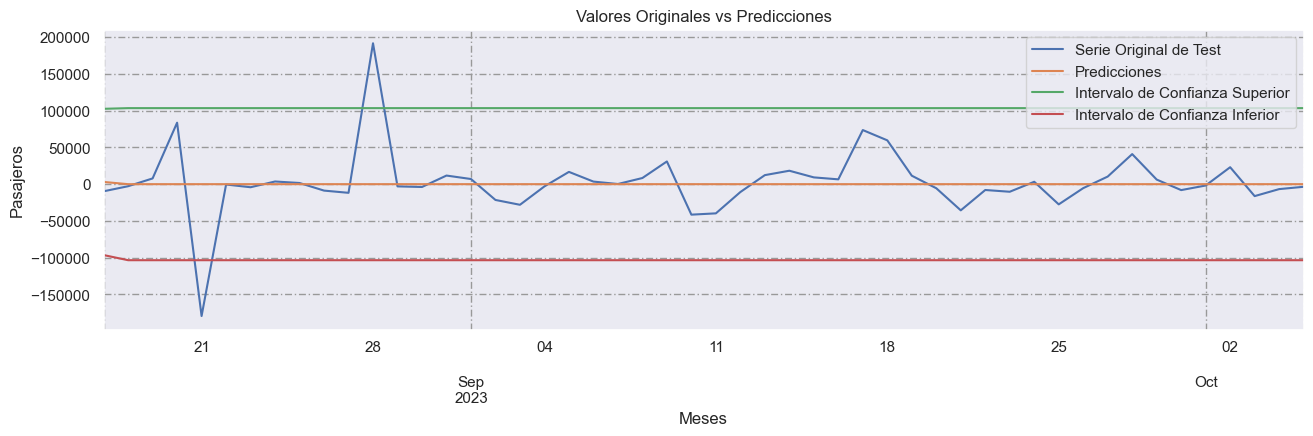

In [47]:
predicciones_arima = modelo_arima.get_forecast(50)

graficar_pred(test_diff_7[:50], predicciones_arima.predicted_mean, predicciones_arima.conf_int())

In [48]:
evaluar_metricas(test_diff_7[:50], predicciones_arima.predicted_mean)

MSE: 1947706053.3166323
MAE: 22844.929613831475
RMSE: 44132.822856878665
MAPE: 1.0063


In [49]:
datos = {'Modelo': ['ARIMA'],
         'AIC': [modelo_arima.aic],
         'BIC': [modelo_arima.bic],
         'MAE': [modelo_arima.mae],
         'MSE': [modelo_arima.mse]}


modelos_residuos = pd.DataFrame(datos)
modelos_residuos

,Modelo,AIC,BIC,MAE,MSE
0,ARIMA,16643.637348,16652.67859,27537.176499,2.572579e+09


# Pregunta 8

Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).

# Pregunta 9

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

# Pregunta 10

Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.

# Pregunta 11

Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad. Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis.

# Pregunta 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior. 

Opcional: Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.